<a href="https://colab.research.google.com/github/Clalva02/TFG/blob/main/TFG_RedClasificaci%C3%B3nPolos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from enum import Enum
from matplotlib import pyplot
import random
!pip install pandas 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

In [2]:
import sys
from keras.optimizers import SGD, Adam
import sklearn.metrics

In [3]:
mu=500 #masa reducida
i_lbd_bg1=50 #numero de lambdas en set 1
i_gamma=100 #numero de gammas en set 1
i_lbd_bg2=50 #numero de lambdas en set 2
i_alfa=10 #numero de alfas en set 2
i_beta=10 #numero de betas en set 2

class DataSet(Enum): #usamos la funcion enum para distinguir ambos sets de datos
    one=1
    two=2

def delta_bg(p,eta,lbd_bg):
    return eta*np.arctan(p/lbd_bg)

def S1(p,eta,lbd_bg,gam):
    dlt=delta_bg(p,eta,lbd_bg)
    return np.exp(2j*dlt)*(-(p+1j*gam)/(p-1j*gam))

def f1(E,eta,lbd_bg,gam):
    p = np.sqrt(2 * mu * E)
    np.seterr(invalid="ignore") #imponemos que ignore en caso de que el argumento de la raiz sea negativo
    return np.where(p<0.0000001,eta/lbd_bg,(S1(p,eta,lbd_bg,gam)-1.0)/(2j*p)) #indicamos que nos devuelva la funcion solo para valores de ¿momento negativos?

def S2(p,eta,lbd_bg,alfa,beta):
    return np.exp(2j*delta_bg(p,eta,lbd_bg))*((p-1j*beta)**2-alfa**2)/((p+1j*beta)**2-alfa**2)

def f2(E,eta,lbd_bg,alfa,beta):
    p = np.sqrt(2 * mu * E)
    np.seterr(invalid="ignore")
    return np.where(p<0.0000001,eta/lbd_bg,(S2(p,eta,lbd_bg,alfa,beta)-1.0)/(2j*p))

def produceLambdas(lbd_min,lbd_max,dataset): #producimos lambdas aleatoria para ambos sets
    if dataset==DataSet.one:
        return np.random.uniform(lbd_min,lbd_max,i_lbd_bg1)
    else:
        return np.random.uniform(lbd_min, lbd_max, i_lbd_bg2)

def produceGammas(lbd_bg,mid,max): #producimos gammas aleatoria para el set 2
    counter=1
    gammas=[]
    while counter<=i_gamma:
        x=np.random.uniform(-0.9*lbd_bg,max)
        if -mid<x<mid:
            continue
        gammas.append(x)
        counter+=1

    return np.array(gammas)

def plotf1sq(eta,lbd_bg,gam):
    en=energies(2000)
    f1sq=np.abs(f1(en,eta,lbd_bg,gam))**2
    pp.plot(en,f1sq)
    pp.show()

def plotf2sq(eta,lbd_bg,alpha,beta):
    en=energies()
    f1sq=np.abs(f2(en,eta,lbd_bg,alpha,beta))**2
    pp.plot(en,f1sq)
    pp.show()

def energies(bins=200):
    delta=100.0/bins
    return np.arange(0+delta,100+delta,delta)

def printHeader(dataSet,file,energies):
    if dataSet==DataSet.one:
        file.write("{};{};{};".format("eta","Lbd_bg","gamma"))
        for e in energies:
            file.write("{};".format(e))
        file.write("{}\n".format("label"))
    else:
        file.write("{};{};{};{};".format("eta", "Lbd_bg", "alpha","beta"))
        for e in energies:
            file.write("{};".format(e))
        file.write("{}\n".format("label"))


def generateData(dataset):
    iter=0
    if dataset==DataSet.one:
        etas= np.arange(-1,-5,-1)
        fname="dataI.csv"
    else:
        etas=np.array([-4,-3,-1,0])
        fname = "dataII.csv"
    file =open(fname,"w")
    energ=energies()
    printHeader(dataset,file,energ)
    if dataset==DataSet.one:
        lambdas = produceLambdas(200, 1200, DataSet.one)
        for l in lambdas:
            gammas=produceGammas(l,10,200)
            for g in gammas:
                for et in etas:
                    file.write("{};{};{};".format(et,l,g))
                    for en in energ:
                        fsq=np.abs(f1(en,et,l,g))**2
                        file.write("{};".format(fsq))
                    if g>0:
                        file.write("{}".format(0))
                    else:
                        file.write("{}".format(1))
                    file.write("\n")
                    iter+=1
                    #print("Iteration: ",iter)
    else:
        lambdas = produceLambdas(200, 1200, DataSet.two)
        alfas=np.random.uniform(1.0,300.0,i_alfa)
        betas=np.random.uniform(50.0,200.0,i_beta)
        for l in lambdas:
                for et in etas:
                    for a in alfas:
                        for b in betas:
                            file.write("{};{};{};{};".format(et,l,a,b))
                            for en in energ:
                                fsq = np.abs(f2(en, et, l, a, b)) ** 2
                                file.write("{};".format(fsq))
                            if b > a:
                                file.write("{}".format(1))
                            else:
                                file.write("{}".format(2))
                            file.write("\n")
                            iter += 1
                            #print("Iteration: ", iter)

    file.close()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
values=pd.read_csv("/content/drive/MyDrive/TFG/dataI.csv",sep=";")
X=values.iloc[:,3:-1]
Y=np.ravel(values.label)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=21)
# Import `StandardScaler` from `sklearn.preprocessing`
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(np.shape(X_train),np.shape(Y_train),np.shape(X_test),np.shape(Y_test))
print(type(X_train),type(Y_train),type(X_test),type(Y_test))

(150000, 200) (150000,) (50000, 200) (50000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [6]:
values2=pd.read_csv("/content/drive/MyDrive/TFG/dataII.csv",sep=";")
X2=values2.iloc[:,4:-1]
Y2=np.ravel(values2.label)
def tempMap(Y):
    return np.where(Y==2,0,1)
def tempUnmap(Y):
    return np.where(Y==0,2,1)
Y_temp2=tempMap(Y2)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y_temp2, random_state=22)
scaler2 = StandardScaler().fit(X_train2)
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [8]:
Xt=np.concatenate((X,X2),axis=0)
Yt=np.concatenate((Y,Y2),axis=0)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xt, Yt, random_state=22)
scaler3 = StandardScaler().fit(Xtrain)
Xtrain = scaler3.transform(Xtrain)
Xtest = scaler3.transform(Xtest)
print(np.shape(Xtrain),np.shape(Ytrain),np.shape(Xtest),np.shape(Ytest))
print(type(Xtrain),type(Ytrain),type(Xtest),type(Ytest))

(300000, 200) (300000,) (100000, 200) (100000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
Ytrain = to_categorical(Ytrain)
Ytest= to_categorical(Ytest)

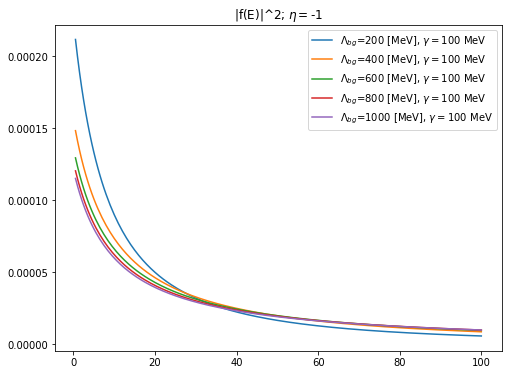

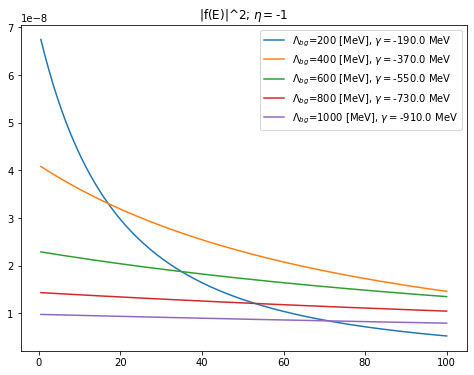

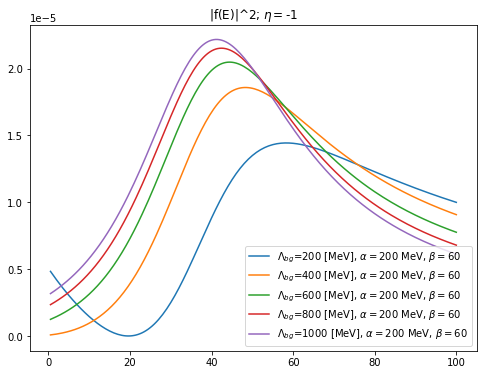

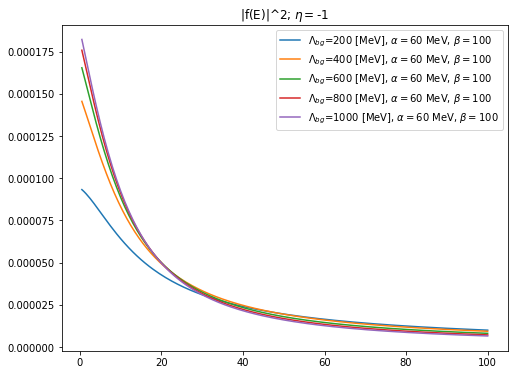

In [34]:
E=np.arange(0+0.5,100+0.5,0.5)
eta=-1
plt.figure(figsize=(8,6))
plt.title(r"|f(E)|^2; $\eta=$"+str(eta))
for lbd in (np.arange(200,1200,200)):
    gam1=100
    plt.plot(E,np.abs(f1(E,eta,lbd,gam1))**2,
            label=r'$\Lambda_{bg}$='+str(lbd)+r" [MeV], $\gamma=$"+str(gam1)+" MeV")
    plt.legend()

plt.show()
eta=-1
plt.figure(figsize=(8,6))
plt.title(r"|f(E)|^2; $\eta=$"+str(eta))
for lbd in (np.arange(200,1200,200)):
    gam2=(-10-0.9*lbd)
    plt.plot(E,np.abs(f1(E,eta,lbd,gam2))**2,label=r'$\Lambda_{bg}$='+str(lbd)+r" [MeV], $\gamma=$"+str(gam2)+" MeV")
    plt.legend()

plt.show()
eta=-1
plt.figure(figsize=(8,6))
plt.title(r"|f(E)|^2; $\eta=$"+str(eta))
for lbd in (np.arange(200,1200,200)):
    alpha2=200
    beta2=60
    plt.plot(E,np.abs(f2(E,eta,lbd,alpha2,beta2))**2,
            label=r'$\Lambda_{bg}$='+str(lbd)+r" [MeV], $\alpha=$"+str(alpha2)+r" MeV, $\beta=$"+str(beta2))
    plt.legend()

plt.show()
E=np.arange(0+0.5,100+0.5,0.5)
eta=-1
plt.figure(figsize=(8,6))
plt.title(r"|f(E)|^2; $\eta=$"+str(eta))
for lbd in (np.arange(200,1200,200)):
    alpha2=60
    beta2=100
    plt.plot(E,np.abs(f2(E,eta,lbd,alpha2,beta2))**2,
            label=r'$\Lambda_{bg}$='+str(lbd)+r" [MeV], $\alpha=$"+str(alpha2)+r" MeV, $\beta=$"+str(beta2))
    plt.legend()

plt.show()

In [10]:
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(200,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, Y_train,validation_split = 0.15,epochs=40, verbose=1)
loss , acc = model.evaluate(X_test, Y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

In [ ]:
model.save('/content/drive/MyDrive/TFG/modelMS1')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/TFG/modelMS1/Acuracy.png')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/TFG/modelMS1/Loss.png')
plt.show()

In [ ]:
score = model.evaluate(X_test,Y_test,verbose=1)
Y_pred=model.predict(X_test)
Y_pred=Y_pred.flatten()
Y_pred=np.round(Y_pred)
Confusion = confusion_matrix(Y_test, Y_pred, normalize='true')
print(confusion_matrix(Y_test, Y_pred, normalize=None))
CM = ConfusionMatrixDisplay(Confusion, display_labels=np.arange(25) )
CM.plot(cmap= 'Blues')
plt.savefig('/content/drive/MyDrive/TFG/modelMS1/CM.png')
plt.show()

In [ ]:
history.history['val_loss'][19]=0.028

In [ ]:
history=model.fit(X_train2, Y_train2,validation_split = 0.15,epochs=40, verbose=1) #Verbose=0 (silent) Verbose=1 (progress bar)

Epoch 1/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.8129 - accuracy: 0.8151 - val_loss: 0.3052 - val_accuracy: 0.8588
Epoch 2/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2911 - accuracy: 0.8785 - val_loss: 0.2482 - val_accuracy: 0.8900
Epoch 3/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2751 - accuracy: 0.8848 - val_loss: 0.2404 - val_accuracy: 0.9020
Epoch 4/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2631 - accuracy: 0.8896 - val_loss: 0.2807 - val_accuracy: 0.8641
Epoch 5/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2527 - accuracy: 0.8939 - val_loss: 0.2331 - val_accuracy: 0.8994
Epoch 6/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2468 - accuracy: 0.8972 - val_loss: 0.2232 - val_accuracy: 0.9130
Epoch 7/40
3985/3985 [==============================] - 9s 2ms/step - loss: 0.2436 - accuracy: 0.8980 - val_loss: 0.2513 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TFG/modelMS2/assets


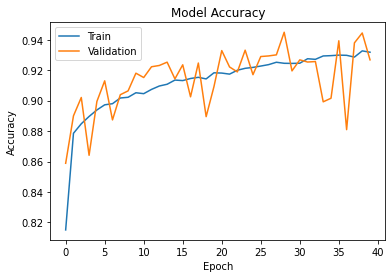

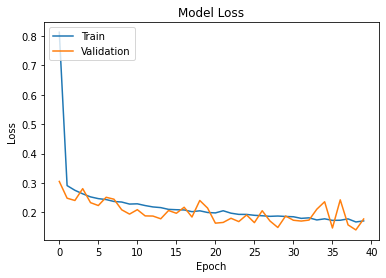

[[21470  1621]
 [ 2159 24750]]


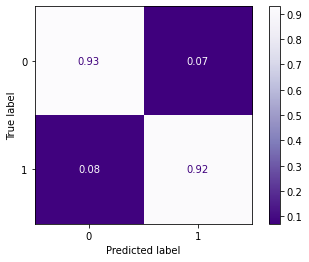

In [ ]:
model.save('/content/drive/MyDrive/TFG/modelMS2')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/TFG/modelMS2/Acuracy.png')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/TFG/modelMS2/Loss.png')
plt.show()
Y_pred2=model.predict(X_test2)
Y_pred2=Y_pred2.flatten()
Y_pred2=np.round(Y_pred2)
Confusion = confusion_matrix(Y_test2, Y_pred2, normalize='true')
print(confusion_matrix(Y_test2, Y_pred2, normalize=None))
CM = ConfusionMatrixDisplay(Confusion, display_labels=np.arange(25) )
CM.plot(cmap= 'Purples_r')
plt.savefig('/content/drive/MyDrive/TFG/modelMS2/CM.png')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(200,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Xtrain,Ytrain,shuffle=False , epochs=40,batch_size= 100, validation_split=0.25, verbose=1)
_ , acc = model.evaluate(Xtest, Ytest, verbose=0)
print('> %.3f' % (acc * 100.0))

Epoch 1/40
2250/2250 [==============================] - 8s 4ms/step - loss: 0.3179 - accuracy: 0.8093 - val_loss: 0.1887 - val_accuracy: 0.8924
Epoch 2/40
2250/2250 [==============================] - 8s 3ms/step - loss: 0.1982 - accuracy: 0.8920 - val_loss: 0.1565 - val_accuracy: 0.9220
Epoch 3/40
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1694 - accuracy: 0.9117 - val_loss: 0.1385 - val_accuracy: 0.9303
Epoch 4/40
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1552 - accuracy: 0.9217 - val_loss: 0.1143 - val_accuracy: 0.9454
Epoch 5/40
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1391 - accuracy: 0.9313 - val_loss: 0.1080 - val_accuracy: 0.9516
Epoch 6/40
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1309 - accuracy: 0.9358 - val_loss: 0.0937 - val_accuracy: 0.9574
Epoch 7/40
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1239 - accuracy: 0.9397 - val_loss: 0.1050 - val_accuracy:

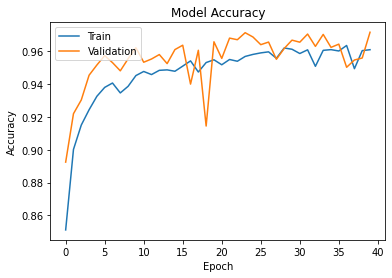

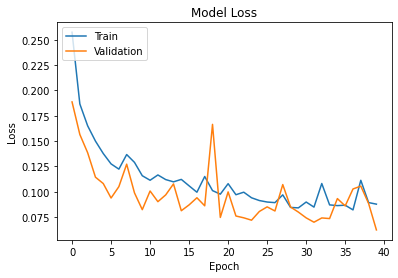

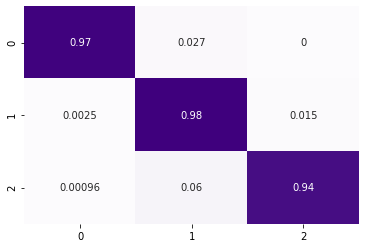

In [ ]:
#model.save('/content/drive/MyDrive/TFG/CNN1')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/TFG/CNN1/Acuracy.png')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/TFG/CNN1/Loss.png')
plt.show()
Ypred=np.argmax(model.predict(Xtest),axis=1)
Ytest3=np.argmax(Ytest,axis=1)
confusion = sklearn.metrics.confusion_matrix(Ytest3,Ypred,normalize='true')
import seaborn as sb
sb.heatmap(confusion,cbar=False,cmap='Purples',annot=True)
#plt.savefig('/content/drive/MyDrive/TFG/CNN1/CM.png')
plt.show()